# Grover's algorithm applied to a satisfiability problem
 
 The 3-SAT problem is a well known NP-complete problem. It consists in looking for vectors : $$(x_0, . . . , x_{n-1}) \in \{0, 1\}^n$$
satisfying a given predicate f in the form of a conjunction of clauses
which are all 3-disjunctions.


### answer 0 :

We condider the the predicate f defined as : 
$$f(x_0,x_1,x_2,x_3,x_4) = (\overline{x_0}\cup x_1)\cap(x_0\cup x_1 \cup \overline{x_2})\cap(x_2\cup x_3)\cap(\overline{x_1}\cup\overline{x_2}\cup x_3)\cap(\overline{x_3}\cup \overline{x_4})\cap(\overline{x_2}\cup \overline{x_3}\cup x_4)$$
There are 3 possible solutions :
$$v_1 = (0, 0, 0, 1, 0)\qquad v_2 = (0, 1, 0, 1, 0) \qquad v_3 = (1, 1, 0, 1, 0)$$

### answer 1 :

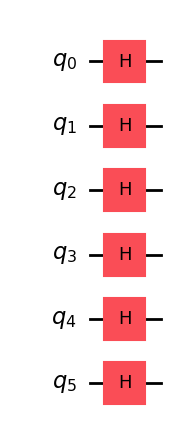

In [8]:

circ = QuantumCircuit(6)

for i in range(6):
    circ.h(i)
circ.draw('mpl')